### DoS Attach Detection (MLP)

In this notebook we are going to create a `Multi-Layer Perceptron (MLP)` model that will accurately detect and predict `DoS` attaches. Using the dataset that was obtained on [`www.unb.ca`](https://www.unb.ca/cic/datasets/ids-2017.html).

> https://www.unb.ca/cic/datasets/ids-2017.html


In the following code cell we are going to install all the packages that we are going to use in this notebook.

In [148]:
!pip install helperfns kaggle pigmenta -q

In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [149]:
import warnings
import random
import os
import time
import json

import pandas as pd
import numpy as np
import seaborn as sns

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from sklearn.utils import resample
from pigmenta import PALETTES

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import xgboost as xgb
from helperfns.visualization import plot_classification_report, plot_complicated_confusion_matrix
warnings.filterwarnings("ignore")


print("xgb:", xgb.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)

xgb: 3.0.4
pandas: 2.2.2
numpy: 2.0.2
torch: 2.8.0+cu126


### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [150]:
SEED = 23
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data
The dataset that we will be using is the [`Intrusion detection evaluation dataset (CIC-IDS2017)`](https://www.unb.ca/cic/datasets/ids-2017.html)

> URL: https://www.unb.ca/cic/datasets/ids-2017.html

We are going to focus on the `Wednesday-workingHours.pcap_ISCX` csv file for this task.



In the following code cell we are going to read the `csv` file and check the first `2` rows in the dataset.

In [152]:
dataframe = pd.read_csv("Wednesday-workingHours.pcap_ISCX.csv")
dataframe.head(2)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In the following code cell we are going to drop null and na values from the dataframe if they exists. Additionally we are going to convert infinity values to na values and we drop them as well.

In [153]:
dataframe = dataframe.replace([np.inf, -np.inf], np.nan)
if any(dataframe.isna().any()):
    dataframe.dropna(inplace=True)

In the following code cell we are going to remove white spaces on column names.

In [154]:
dataframe.columns = dataframe.columns.str.replace(' ', '')
dataframe.head(2)

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Feature Selection

Our dataset contain `77` features and `1` target label. We are going to start by analysing which features are important using `XGBoost` and we will select those features to train a `MLP` deep learning model.


First we are going to split the dataset into `2` sets.

In [155]:
train, test = train_test_split(dataframe, test_size=0.3, random_state=SEED)

Then we are going to extract the features and labels.

In [156]:
y_train = train.Label.values
y_test = test.Label.values

In [157]:
train.drop(columns=["Label"], inplace=True)
test.drop(columns=["Label"], inplace=True)

We are going to use the `LabelEncoder` to convert our features to labels.

In [158]:
encoder = LabelEncoder()

def scale_labels(encoder, train, test):
    train = encoder.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), encoder.transform(test.reshape(-1, 1)).reshape(-1)

train_threats, test_threats = scale_labels(encoder, y_train, y_test)

All the features in the dataframe are numeric, we are going to use a standard scaler to scale the features.

In [159]:
scale_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("numerical pre-processing", scale_pipeline, train.columns)
], remainder='passthrough')
train_features = ct.fit_transform(train)
test_features = ct.transform(test)
train_features

array([[-3.57138424e-01,  1.27614426e+00, -5.06026308e-03, ...,
        -1.05949930e-01,  1.55694775e+00,  1.59439012e+00],
       [-3.32690171e-01, -6.56251194e-01, -9.76575305e-03, ...,
        -1.05949930e-01, -5.86550627e-01, -5.72011294e-01],
       [-3.57138424e-01,  1.33015672e+00, -1.53114560e-03, ...,
        -1.05949930e-01,  1.61663354e+00,  1.65471365e+00],
       ...,
       [-3.34087214e-01, -6.53909285e-01,  1.14089518e-02, ...,
        -1.05949930e-01, -5.86550627e-01, -5.72011294e-01],
       [-3.34087214e-01, -6.56250680e-01, -9.76575305e-03, ...,
        -1.05949930e-01, -5.86550627e-01, -5.72011294e-01],
       [-3.58852977e-01, -6.56248555e-01, -9.76575305e-03, ...,
        -1.05949930e-01, -5.86550627e-01, -5.72011294e-01]])

We are going to create a function that will extract feature importance using `xgb`.

In [160]:
def get_feature_impotance(train_features, train_labels, test_features, test_labels):
    xgb_model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    xgb_model.fit(
        train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        verbose=100
   )
    return xgb_model.feature_importances_

fi = get_feature_impotance(train_features, train_threats, test_features, test_threats)

[0]	validation_0-rmse:1.02236	validation_1-rmse:1.02256
[100]	validation_0-rmse:0.48277	validation_1-rmse:0.48294
[200]	validation_0-rmse:0.31714	validation_1-rmse:0.31676
[300]	validation_0-rmse:0.25393	validation_1-rmse:0.25241
[400]	validation_0-rmse:0.21857	validation_1-rmse:0.21625
[500]	validation_0-rmse:0.19868	validation_1-rmse:0.19613
[600]	validation_0-rmse:0.18523	validation_1-rmse:0.18251
[700]	validation_0-rmse:0.17563	validation_1-rmse:0.17273
[800]	validation_0-rmse:0.16858	validation_1-rmse:0.16560
[900]	validation_0-rmse:0.16274	validation_1-rmse:0.15974
[999]	validation_0-rmse:0.15761	validation_1-rmse:0.15448


We are then going to take the extracted features and create a dataframe on it. This dataframe will helps us to sort the feature based on the importance score in predicting `DoS` threats.

In [161]:
threats_fi = pd.DataFrame(
    data=fi,
    index=train.columns,
    columns=['importance']
)
threats_fi.head()

,importance
DestinationPort,0.069533
FlowDuration,0.003378
TotalFwdPackets,0.000541
TotalBackwardPackets,0.002425
TotalLengthofFwdPackets,0.001111


We are going to set a threshhold of `2%` on the fatures so that the features that has importance less than `2%` we ignore them.

In [162]:
selected_fi = threats_fi.sort_values('importance', ascending=False).loc[threats_fi.importance >= 0.02]
selected_fi.head(10)

,importance
BwdPackets/s,0.397280
BwdPacketLengthStd,0.096771
MinPacketLength,0.077367
DestinationPort,0.069533
PSHFlagCount,0.057434
FwdIATTotal,0.032330
FINFlagCount,0.024655
FwdPSHFlags,0.024299
act_data_pkt_fwd,0.023209


We are then going to visually plot how each feature is important in the Threat detection and prediction.

<Figure size 400x200 with 0 Axes>

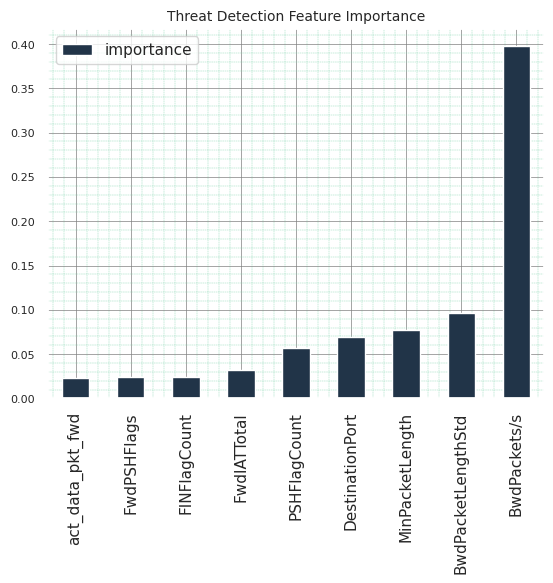

In [163]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(4, 2))
selected_fi.sort_values('importance').plot(kind='bar', color=PALETTES.cold[23])
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.yticks(fontsize=8)
plt.title('Threat Detection Feature Importance', fontsize=10)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

Now we are going to select the dataframe columns based on the features that has been selected and the respective labels.

In [164]:
selected_dataframe = dataframe[["Label"] + list(selected_fi.index)]
selected_dataframe.head(2)

,Label,BwdPackets/s,BwdPacketLengthStd,MinPacketLength,DestinationPort,PSHFlagCount,FwdIATTotal,FINFlagCount,FwdPSHFlags,act_data_pkt_fwd
0,BENIGN,26.104208,0.000000,6,80,0,0,0,0,0
1,BENIGN,10438.413360,89.278777,0,389,1,479,0,0,4


### Data Insights

In this section of the notebook we are going to look in the data interms of how the data is distributed using charts.

In [165]:
samples = dict(selected_dataframe.Label.value_counts())
samples

{'BENIGN': np.int64(439683),
 'DoS Hulk': np.int64(230124),
 'DoS GoldenEye': np.int64(10293),
 'DoS slowloris': np.int64(5796),
 'DoS Slowhttptest': np.int64(5499),
 'Heartbleed': np.int64(11)}

Next we are going to check the distribution of each class in the dataset using a pie chat.

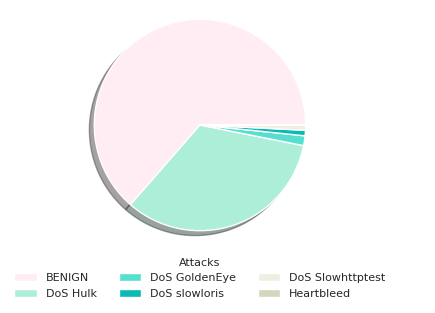

In [166]:
plt.figure(figsize=(3, 3))

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    textprops={'color': 'white', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.gradient
)
plt.axis('equal')
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Attacks", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

Next we want to balance the dataset based on the `DoS Slowhttptest` label and remove `Heart bleed` attack.

In [167]:
selected_dataframe = selected_dataframe[selected_dataframe.Label != 'Heartbleed']
selected_dataframe.Label.unique()

array(['BENIGN', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'DoS GoldenEye'], dtype=object)

In [168]:
new_dataframe = selected_dataframe.copy()

min_class_count = new_dataframe['Label'].value_counts().min()
downsampled_list = []
for label in new_dataframe['Label'].unique():
    class_df = new_dataframe[new_dataframe['Label'] == label]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

Next we are going to visualize the balanced dataset using a pie chart.

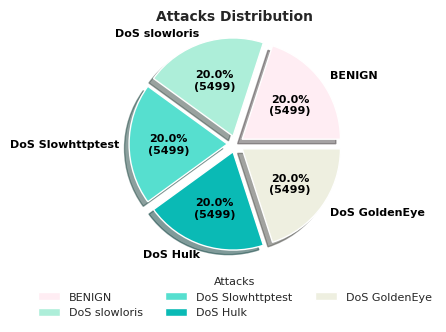

In [169]:
samples = dict(balanced_df.Label.value_counts())

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.gradient,
    explode=[.05 for _ in range(len(samples))]
)
plt.axis('equal')
plt.title("Attacks Distribution", fontsize=10, weight="bold")
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Attacks", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In the following code cell we are going to split the data into `train`, `validation` and `test` sets.

In [170]:
train, test = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=SEED)

In the following code cell we are going to visualize the examples in each set.

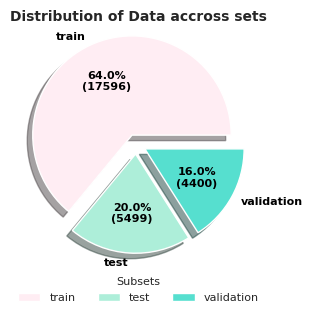

In [171]:
dist_sets = {'train': len(train), 'test': len(test), 'validation': len(valid)}
plt.figure(figsize=(3, 3))
plt.title("Distribution of Data accross sets", fontsize=10, weight="bold")
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(balanced_df)),
    textprops={'color': 'black', 'fontsize':8, 'weight': 'bold'}, radius=.5,
    colors=PALETTES.gradient, shadow=True, explode=[.05 for _ in range(3)]
)
plt.axis('equal')
plt.legend(
    labels=list(dist_sets.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Subsets", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In the next code cell we are going to visualize the distribution of each target label accross each dataset subset using a pie chat.

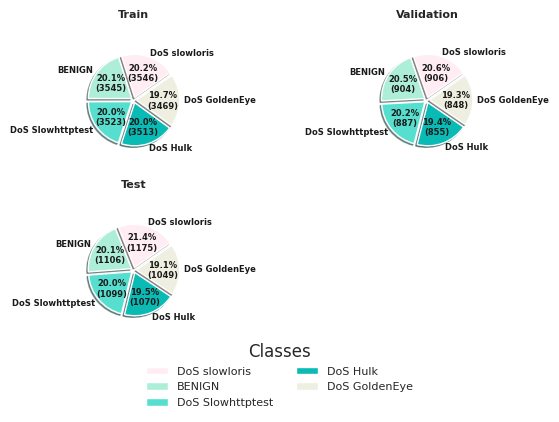

In [174]:
data_samples = {
    "train":  dict(train.Label.value_counts()),
    "validation": dict(valid.Label.value_counts()), "test": dict(test.Label.value_counts())
}

labels = list(next(iter(data_samples.values())).keys())
n_charts = len(data_samples)
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 2 * n_rows))
axes = axes.flatten()

for i, (name, values_dict) in enumerate(data_samples.items()):
    values = list(values_dict.values())
    wedges, texts, autotexts = axes[i].pie(
        values,
        labels=labels,
        autopct=lambda x: fmt(x, sum(values)),
        startangle=35,
        pctdistance=0.6,
        shadow=True,
        textprops={'color': 'k', 'fontsize': 6, 'weight': 'bold'},
        radius=.8,
        colors=PALETTES.gradient,
        explode=[.05 for _ in range(5)]
    )
    axes[i].set_title(name.capitalize(), fontsize=8, weight="bold",  y=1.05)
for j in range(i+1, n_rows*n_cols):
    axes[j].axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.legend(
    wedges, labels, loc="lower center",
    ncol=2, frameon=False, fontsize=8, title="Classes",
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout(rect=[0, 0.12, 1, 1])
plt.show()

In the following code cell we are going to extract the features and labels for each set.

In [175]:
X_train = train.drop(columns=['Label'])
y_train = train.Label.values
X_test = test.drop(columns=['Label'])
y_test = test.Label.values

X_valid = valid.drop(columns=['Label'])
y_valid = valid.Label.values
y_test[:2]

array(['DoS slowloris', 'DoS Hulk'], dtype=object)

In [176]:
X_train.head(2)

,BwdPackets/s,BwdPacketLengthStd,MinPacketLength,DestinationPort,PSHFlagCount,FwdIATTotal,FINFlagCount,FwdPSHFlags,act_data_pkt_fwd
21047,0.000000,0.0,0,80,0,1002,0,0,0
2805,84.889643,0.0,50,53,0,3,0,0,1


We are going to create the encoder object using the  `LabelEncoder` that will encode labels to numerical.

In [177]:
encoder = LabelEncoder()
def encode_labels(encoder, train, test, valid):
    train = encoder.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), encoder.transform(test.reshape(-1, 1)).reshape(-1), encoder.transform(valid.reshape(-1, 1)).reshape(-1)

train_attacks, test_attacks, valid_attacks = encode_labels(encoder, y_train, y_test, y_valid)

In the following code cell we are going to check some examples of transformed labels to see if the transformation was successful.

In [178]:
train_attacks[:2], y_train[:2], encoder.inverse_transform(train_attacks[:2])

(array([2, 0]),
 array(['DoS Hulk', 'BENIGN'], dtype=object),
 array(['DoS Hulk', 'BENIGN'], dtype=object))

In the following code cell we are going to transform the features by scaling them using a standard scaler.

In [179]:
num_features = X_train.columns

scale_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("scale pre-processing", scale_pipeline, num_features)
])

train_features = ct.fit_transform(X_train)
test_features = ct.transform(X_test)
valid_features = ct.transform(X_valid)

In the following code cell we are going to check a sigle feature from the training features.

In [180]:
train_features[0]

array([-0.11760251, -0.5913326 , -0.21560058, -0.18840068, -0.97729786,
       -0.9178222 , -0.24193668, -0.34905035, -0.29231741])

In the following code cell we are going to create the dataset using the `TensorDataset` class. After that we are going to batch the dataset using a batch size of `16` using the `DataLoader` class

In [181]:
trainset = TensorDataset(
    torch.from_numpy(train_features).float(), torch.from_numpy(train_attacks)
)
testset = TensorDataset(
    torch.from_numpy(test_features).float(), torch.from_numpy(test_attacks)
)
validset = TensorDataset(
    torch.from_numpy(test_features).float(), torch.from_numpy(test_attacks)
)

BATCH_SIZE = 16

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In the following code cell we are going to create check a single example of training data.

In [182]:
example = next(iter(trainloader))
example[0], example[1]

(tensor([[-0.1176, -0.5913, -0.2156, -0.1884,  1.0232,  0.5061, -0.2419, -0.3491,
          -0.2923],
         [ 0.2309, -0.5913,  0.7326, -0.1914, -0.9773, -0.9178, -0.2419, -0.3491,
          -0.1532],
         [-0.1176,  0.1854, -0.2156, -0.1884,  1.0232, -0.6109, -0.2419, -0.3491,
          -0.1532],
         [-0.1173, -0.5913, -0.2156, -0.1884, -0.9773, -0.9178, -0.2419, -0.3491,
          -0.2923],
         [-0.1176,  1.4042, -0.2156, -0.1884,  1.0232, -0.6109, -0.2419, -0.3491,
          -0.1532],
         [-0.1176, -0.5913, -0.2156, -0.1884, -0.9773, -0.1258, -0.2419, -0.3491,
          -0.2923],
         [-0.1176,  2.3698, -0.2156, -0.1884, -0.9773,  1.3343,  4.1333, -0.3491,
           0.1249],
         [-0.1176, -0.5913, -0.2156, -0.1884,  1.0232,  0.5061, -0.2419, -0.3491,
          -0.2923],
         [-0.1176, -0.5913, -0.2156, -0.1884, -0.9773, -0.6719, -0.2419, -0.3491,
          -0.2923],
         [-0.1174,  0.7847, -0.2156, -0.1884,  1.0232, -0.8951, -0.2419, -0.3491,


### Creating a Model (MLP)

We are going to use a Linear layers to create a `Multi-layer Perceptron (MLP)` model that does the classification of the perfect `DoS` attack.

In [183]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=.5):
    super(MLP, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 16),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(16, output_dim)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    x = self.classifier(x)
    return x

In the following code cell we are going to create the instance of our model.

In [184]:
input_dim = test_features.shape[1]
output_dim = 1 if len(encoder.classes_) == 2 else len(encoder.classes_)
mlp = MLP(input_dim=len(X_train.columns), output_dim=len(encoder.classes_), dropout=.11).to(device)
mlp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.11, inplace=False)
    (3): Linear(in_features=128, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.11, inplace=False)
    (6): Linear(in_features=16, out_features=5, bias=True)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [185]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return total_params, trainable_params

total_params, trainable_params = count_params(mlp)

tabulate_data(["","Total Parameters", "Trainable Parameteres"],
           [["MLP", f'{total_params:,}', f'{trainable_params:,}']],
           "MODEL PARAMETERS")

MODEL PARAMETERS
+-----+------------------+-----------------------+
|     | Total Parameters | Trainable Parameteres |
+-----+------------------+-----------------------+
| MLP |            3,429 |                 3,429 |
+-----+------------------+-----------------------+


### Optimizer and Criterion
In the following code cell we are going to define the `optimizer` and `criterion`. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [186]:
optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the `predicted` labels and `real` labels.

In [187]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [188]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).long()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).long()
      y_pred = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training History

When training the model we are going to  keep on tracking the training history of the model. The following `History` class is a data structure for our training history.

In [189]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [190]:
EPOCHS = 40
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [191]:
history, training_end, last_saved_epoch = train_model(
    mlp, 'mlp.pt', trainloader, optimizer, criterion, device, validloader
)

mlp: EPOCH 01/40: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.558 |   82.97% | 0:00:03.15 |
| Validation | 0.316 |   90.09% |            |
+------------+-------+----------+------------+
mlp: EPOCH 02/40: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.329 |   89.58% | 0:00:03.02 |
| Validation | 0.258 |   92.47% |            |
+------------+-------+----------+------------+
mlp: EPOCH 03/40: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.284 |   91.28% | 0:00:02.11 |
| Validation | 0.232 |   92.74% |            |
+------------+-------+----------+------------+
mlp: EPOCH 04/40: (saving)
+------------+-------+----------+------------+

In the following code cell we are going to visualize the model's training history and last saved epoch.

In [192]:
rows = [
      ["MLP", f'{EPOCHS}', f'{last_saved_epoch}', f'{hms_string(training_end)}']
]
tabulate_data(['MODEL', 'TOTAL EPOCHS', "LAST SAVED EPOCH", "TOTAL TRAINING TIME (s)"],
              rows, "MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH
+-------+--------------+------------------+-------------------------+
| MODEL | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME (s) |
+-------+--------------+------------------+-------------------------+
| MLP   |           40 |               34 |              0:01:32.13 |
+-------+--------------+------------------+-------------------------+


### Training History
In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

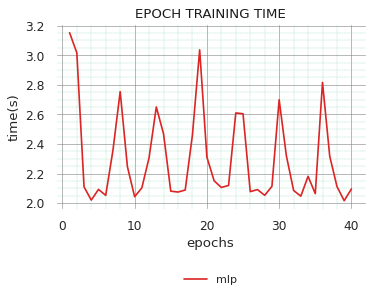

In [193]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color=PALETTES.christmas[1], label='mlp')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for the model that was observed during model training.

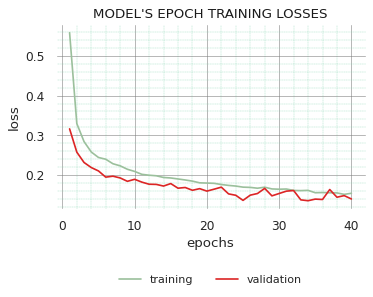

In [194]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color=PALETTES.christmas[0], label='training')
plt.plot(epochs, history.val_losses, color=PALETTES.christmas[1], label='validation')
plt.title("MODEL'S EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

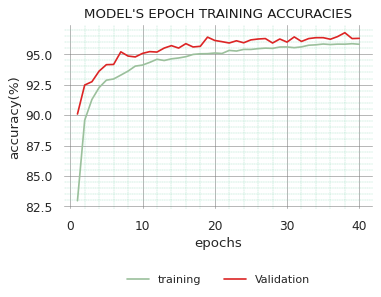

In [195]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color=PALETTES.christmas[0], label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color=PALETTES.christmas[1], label='Validation')

plt.title("MODEL'S EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)


plt.legend(
    fontsize=10, loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3, frameon=False, title_fontsize=8
)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [196]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
mlp.load_state_dict(torch.load('mlp.pt'))
test_loss, test_acc = evaluate(mlp, testloader, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]
tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.135 |   96.36% |            |
+------+-------+----------+------------+


### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.

First we need to get all the predictions from the train dataset.

In [197]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return labels, probs

test_labels, probs = get_predictions(mlp, testloader, device)

Next we are going to convert our predictions from probabilities to real labels.

In [198]:
preds = torch.argmax(probs, 1).numpy().astype(np.int32)
test_labels = test_labels.numpy()

### Confusion Matrix
In the following code cell we are going to visualize the confusion matrix of our model based on the test dataset.

In [199]:
class_names = encoder.classes_
class_names

array(['BENIGN', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest',
       'DoS slowloris'], dtype=object)

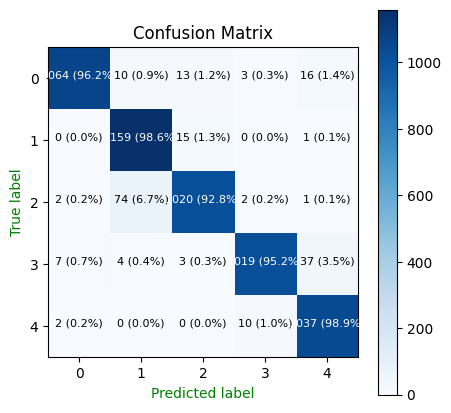

In [207]:
plt.style.use('default')
plot_complicated_confusion_matrix(test_labels, preds, [i for i, _ in enumerate(class_names)],
                                  fontsize=8, figsize=(5, 5), title="Confusion Matrix")

### Classification Report

In the following code cell we are going to the plot the confusion matrix.



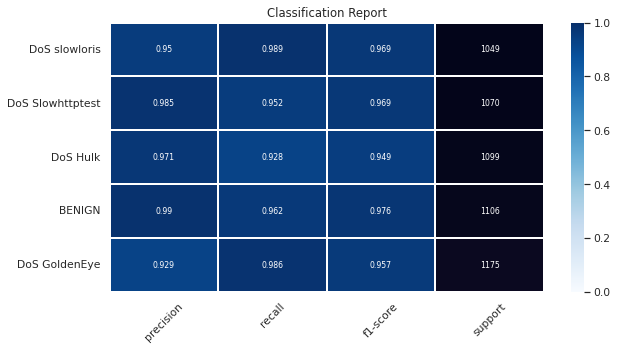

In [201]:
fig, ax = plot_classification_report(test_labels, preds,
                    title='Classification Report',
                    figsize=(10, 5), dpi=70,
                    target_names = class_names)

### Model Inference

In this section of the notebook we are going to make prediction based on the user input using the best save model.

In [202]:
test.reset_index(drop=True).head(6)

,Label,BwdPackets/s,BwdPacketLengthStd,MinPacketLength,DestinationPort,PSHFlagCount,FwdIATTotal,FINFlagCount,FwdPSHFlags,act_data_pkt_fwd
0,DoS slowloris,0.036686,0.000000,0,80,1,109000000,0,0,6
1,DoS Hulk,31.049151,7.778175,0,80,0,488,1,0,1
2,DoS slowloris,0.000000,0.000000,0,80,1,3003730,0,0,0
3,BENIGN,0.242587,737.296413,0,80,1,20500000,0,0,1
4,DoS Hulk,0.050269,3331.638186,0,80,0,99300000,0,0,1
5,DoS GoldenEye,0.000000,0.000000,0,80,0,46500000,0,0,0


Predicting `DoS slowloris`.

In [203]:
details = test.iloc[0].to_dict()
def predict_attack(details, model, device):
  features = pd.DataFrame([details])[num_features]
  features = ct.transform(features)
  features = torch.from_numpy(features).float()
  model.eval()
  with torch.no_grad():
    features = features.to(device)
    y_pred = model(features)
    probabilities = torch.softmax(y_pred.squeeze(), dim=0)
    label = probabilities.argmax(0).item()
    top = {
        "attack": encoder.classes_[label],
        "probability": float(probabilities[label]),
        "label": label
    }
    predictions = [{
        "attack": encoder.classes_[i],
        "probability": float(prob),
        "label": i
    } for i, prob in enumerate(probabilities)]
    return {"top": top, "predictions": predictions}

predict_attack(details, mlp, device)

{'top': {'attack': 'DoS slowloris',
  'probability': 0.6293574571609497,
  'label': 4},
 'predictions': [{'attack': 'BENIGN',
   'probability': 0.024074815213680267,
   'label': 0},
  {'attack': 'DoS GoldenEye',
   'probability': 3.243264654884115e-05,
   'label': 1},
  {'attack': 'DoS Hulk', 'probability': 4.45611519905853e-10, 'label': 2},
  {'attack': 'DoS Slowhttptest',
   'probability': 0.34653526544570923,
   'label': 3},
  {'attack': 'DoS slowloris', 'probability': 0.6293574571609497, 'label': 4}]}

Predicting `DoS Hulk`.

In [204]:
details = test.iloc[1].to_dict()
predict_attack(details, mlp, device)

{'top': {'attack': 'DoS Hulk', 'probability': 0.987604022026062, 'label': 2},
 'predictions': [{'attack': 'BENIGN',
   'probability': 0.012395920231938362,
   'label': 0},
  {'attack': 'DoS GoldenEye',
   'probability': 1.5938866226861137e-08,
   'label': 1},
  {'attack': 'DoS Hulk', 'probability': 0.987604022026062, 'label': 2},
  {'attack': 'DoS Slowhttptest',
   'probability': 2.013514910359504e-10,
   'label': 3},
  {'attack': 'DoS slowloris',
   'probability': 1.7206792631355161e-12,
   'label': 4}]}

### Saving Objects

In the following code cell we are going to save all the objects that we are going to use for inference.

In [205]:
dump({
    "model": num_features,
    "column_transformer": ct,
    "encoder": encoder
}, "attach_buddle_bundle.joblib")
print("Done!")

Done!
